## Семинар 4: "Сверточные сети"

ФИО: Жолковский Евгений Константинович

In [127]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
from scipy.signal import convolve
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [128]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    for i in range(len(signal_convolved)):
        signal_convolved[i] = (signal[i:i+len(kernel)]*kernel[::-1]).sum()
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [129]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

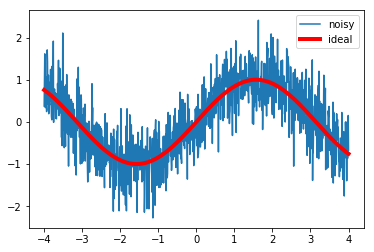

In [130]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [131]:
denoised_signal = t_convolve(noisy_signal, np.array([0.2,0.2,0.2,0.2,0.2]))

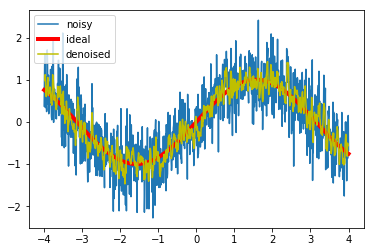

In [132]:
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

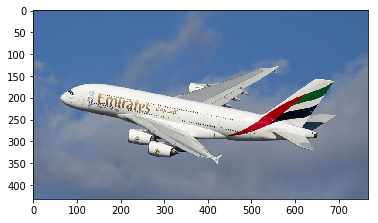

In [133]:
image = plt.imread('image.jpg')
plt.imshow(image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [134]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140])[None, None, :]

In [135]:
color_to_bw.shape, image.shape

((1, 1, 3), (432, 768, 3))

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

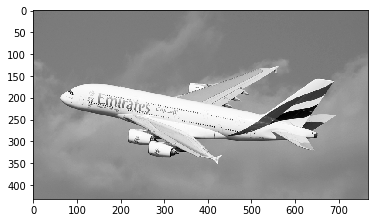

In [136]:
bw_image = convolve(image, color_to_bw[:, :, ::-1], mode='valid')[:, :, 0]
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [137]:
Kx = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
Ky = Kx.T
Gx = convolve(image, Kx[:, :, None], mode='valid').sum(2)
Gy = convolve(image, Ky[:, :, None], mode='valid').sum(2)

Text(0.5,1,'|[Gx, Gy]|')

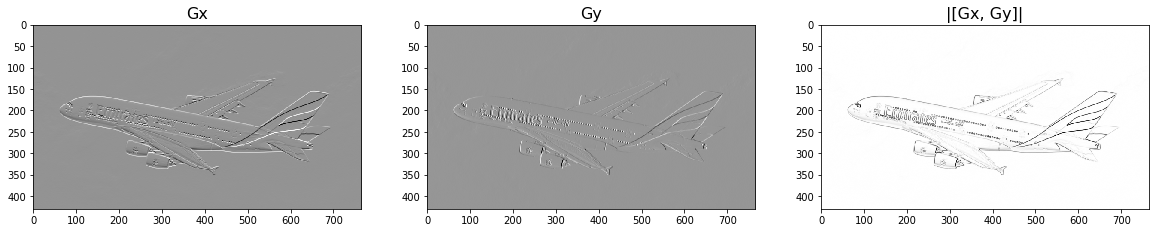

In [138]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(Gx, cmap=plt.cm.Greys)
plt.title('Gx', fontsize=16)
plt.subplot(1, 3, 2)
plt.imshow(Gy, cmap=plt.cm.Greys)
plt.title('Gy', fontsize=16)

edges = np.sqrt(Gx**2+Gy**2)
plt.subplot(1, 3, 3)
plt.imshow(edges, cmap=plt.cm.Greys)
plt.title('|[Gx, Gy]|', fontsize=16)

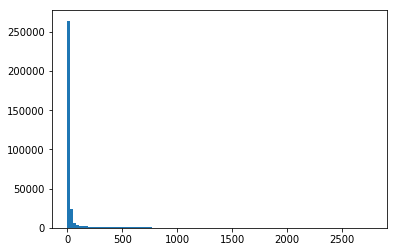

In [139]:
plt.hist(edges.ravel(), bins=100)
plt.show()

Text(0.5,1,'TH=500')

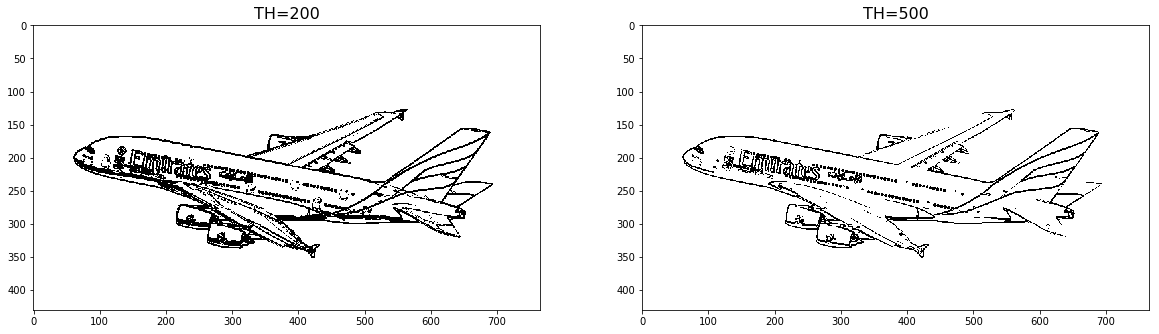

In [147]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(edges > 200, cmap=plt.cm.Greys)
plt.title('TH=200', fontsize=16)
plt.subplot(1, 2, 2)
plt.imshow(edges > 500, cmap=plt.cm.Greys)
plt.title('TH=500', fontsize=16)

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [159]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1

    shape = list(signal.shape)
    shape[-1] = kernel.shape[0]
    result = np.empty(shape)
    for j, k in enumerate(kernel):
        result[:,:,j] = convolve(signal, k, mode='valid')[:,:,0]
    return result.astype(np.uint8)

In [160]:
rgb2bgr = np.eye(3)[:,None,None]

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

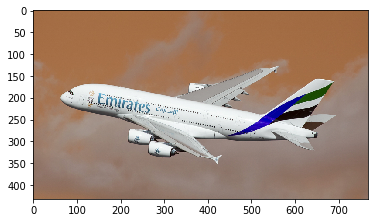

In [161]:
rgb2bgr_img = t_convolve_bank(image, rgb2bgr)

plt.imshow(rgb2bgr_img)

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [151]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    new_shape = [image.shape[0]//2, image.shape[1]//2]
    pooled_img = np.ones((new_shape[0], new_shape[1], 3))
    
    for channel in range(3):
        for y in range(0, new_shape[1]):
            for x in range(0, new_shape[0]):
                pooled_img[x,y,channel] = np.max(image[x*2:x*2+2, y*2:y*2+2, channel])

    return pooled_img.astype(np.uint8)

def medianpool(image, w=2):
    assert(image.ndim == 3)
    new_shape = [image.shape[0]//2, image.shape[1]//2]
    pooled_img = np.ones((new_shape[0], new_shape[1], 3))
    
    for channel in range(3):
        for y in range(0, new_shape[1]):
            for x in range(0, new_shape[0]):
                pooled_img[x,y,channel] = np.median(image[x*2:x*2+2, y*2:y*2+2, channel])

    return pooled_img.astype(np.uint8)

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

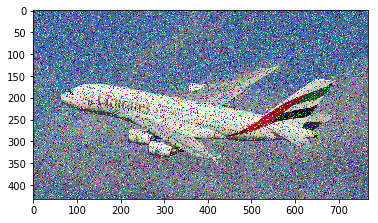

In [152]:
noise_white = np.random.rand(*image.shape) > 0.9
noise_black = np.random.rand(*image.shape) > 0.9
sp_image = np.copy(image)
sp_image[np.where(noise_white)] = 255
sp_image[np.where(noise_black)] = 0
plt.imshow(sp_image)

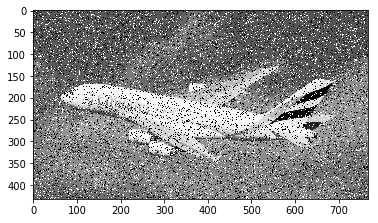

In [153]:
plt.imshow(sp_image[:, :, 0], cmap=plt.cm.Greys_r)

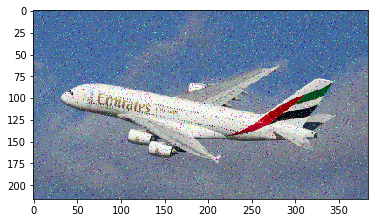

In [154]:
#median pooling
plt.imshow(medianpool(sp_image))

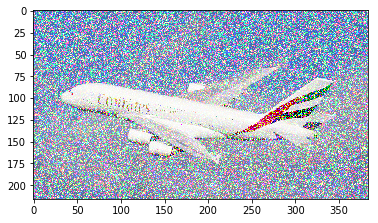

In [155]:
#max pooling
plt.imshow(maxpool(sp_image))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

medianpool справился лучше. В maxpool при попадании "засвеченного" пикселя в квадрат 2 на 2, в котором ищем максимум, новый пиксель становится таким же. При medianpool вероятность такого намного меньше.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Processing...
Done!


In [62]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(42)
    torch.cuda.set_device(2)

In [8]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = Variable(X)
                y = Variable(y)
                
                if use_cuda:
                    X, y = X.cuda(), y.cuda()
                    
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                
                
                if use_cuda:
                    accuracies.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
                else:
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            
            scheduler.step(loss_batch.data[0])
                    
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = Variable(X)
                y = Variable(y)
                
                if use_cuda:
                    X, y = X.cuda(), y.cuda()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                
                if use_cuda:
                    accuracies.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
                else:
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
                    
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

## Сеть 1
### input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax

In [67]:
class NN1(nn.Module):
    def __init__(self):
        super(NN1, self).__init__()
        self.conv_layers = nn.Sequential(   #conv1
                                            nn.BatchNorm2d(1),
                                            nn.Conv2d(1, 8, 3, padding=3, stride=1), 
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
            
                                            #conv2
                                            nn.BatchNorm2d(8),
                                            nn.Conv2d(8, 16, 3, padding=2, stride=1), 
                                            nn.ReLU(),
                                            nn.MaxPool2d(2), 
                                            
                                        )
            
        self.linear_layers = nn.Sequential(
                                            nn.BatchNorm1d(1296),
                                            nn.Linear(1296, 10),
                                            nn.LogSoftmax(dim=1)                                           
                                            )
        torch.nn.init.xavier_normal(self.linear_layers[1].weight)
            
    def forward(self, x):
        
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x) 
        return x

In [12]:
network1 = NN1()
if use_cuda:
    network1 = network1.cuda()

Epoch 19... (Train/Test) NLL: 0.128/0.149	Accuracy: 0.980/0.978

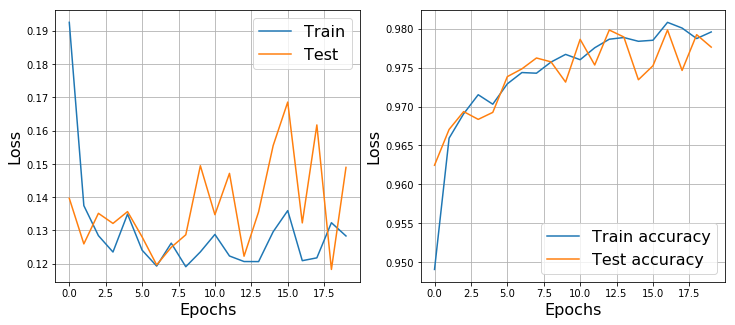

In [13]:
train(network1, epochs=20, learning_rate=0.01)

## Сеть 2
### input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

In [19]:
class NN2(nn.Module):
    def __init__(self):
        super(NN2, self).__init__()
        self.conv_layers = nn.Sequential(   #conv1
                                            nn.BatchNorm2d(1),
                                            nn.Conv2d(1, 8, 3, padding=3, stride=1), 
                                            nn.ReLU(),
            
                                            #conv2
                                            nn.BatchNorm2d(8),
                                            nn.Conv2d(8, 16, 3, padding=2, stride=1), 
                                            nn.ReLU(),
                                            nn.MaxPool2d(2), 
            
                                            #conv3
                                            nn.BatchNorm2d(16),
                                            nn.Conv2d(16, 32, 3, padding=2, stride=1), 
                                            nn.ReLU(),                                            
                                        )
            
        self.linear_layers = nn.Sequential(
                                            nn.BatchNorm1d(11552),
                                            nn.Linear(11552, 10),
                                            nn.LogSoftmax(dim=1)
#                                           
                                            )
        torch.nn.init.xavier_normal(self.linear_layers[1].weight)
            
    def forward(self, x):
        
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x) 
        return x

In [20]:
network2 = NN2()
if use_cuda:
    network2 = network2.cuda()

Epoch 16... (Train/Test) NLL: 0.775/1.323	Accuracy: 0.984/0.978Epoch    17: reducing learning rate of group 0 to 1.0000e-03.
Epoch 19... (Train/Test) NLL: 0.277/0.800	Accuracy: 0.993/0.986

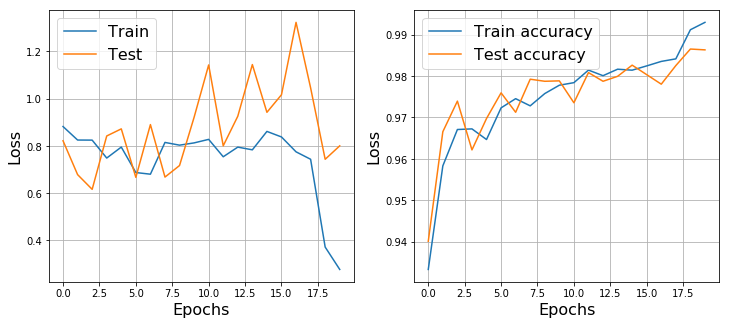

In [21]:
train(network2, epochs=20, learning_rate=0.01)

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

## Сеть 1  - ошибки

In [122]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = Variable(X).cuda()
    y = y.numpy()

    prediction = network1(X)
    prediction = prediction.data.cpu().numpy()
    X = X.data.cpu().numpy()
    
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            #predicted_y.append(prediction.argmax(1))
            logits.append(prediction[i][y[i]])
            
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

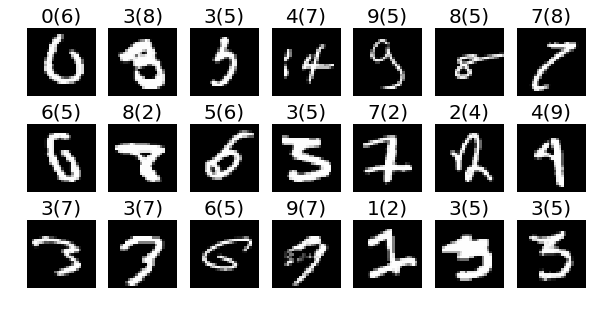

In [123]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

## Сеть 2 - ошибки

In [124]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = Variable(X).cuda()
    y = y.numpy()

    prediction = network2(X)
    prediction = prediction.data.cpu().numpy()
    X = X.data.cpu().numpy()
    
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            #predicted_y.append(prediction.argmax(1))
            logits.append(prediction[i][y[i]])
            
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

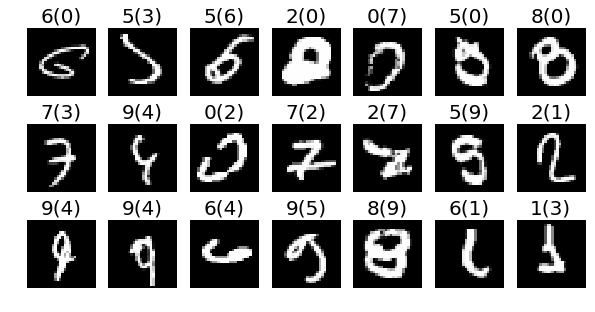

In [125]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')